In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

/home/svetlana.maslenkova/.conda/envs/nlp_project_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102


In [3]:
import os, sys

cwd = os.getcwd()
cwd

'/home/svetlana.maslenkova/Documents/nlp_project'

In [6]:
TRAIN_DATA_PATH = cwd + '/data/dreaddit-train.csv'
TEST_DATA_PATH = cwd + '/data/dreaddit-test.csv'
CORRECTED_LABELS_DATA_PATH = cwd + '/data/stress-scraped.csv'

PRETRAINED_4cat_MODEL_PATH = cwd + '/checkpoints/pretrained_model_4cat_lstm.pt'
PRETRAINED_EKMAN_MODEL_PATH = cwd + '/checkpoints/pretrained_model_ekman.pt'
PRETRAINED_ALL_EMO_MODEL_PATH = cwd + '/checkpoints/pretrained_model_all_emotions_lstm.pt'
PRETRAINED_FULL_EKMAN_MODEL_PATH = cwd + '/checkpoints/pretrained_model_full_ekman_lstm.pt'
PRETRAINED_FSJ_MODEL_PATH = cwd + '/checkpoints/pretrained_FSJ_lstm_lr0.00005.pt'

DREDDIT_FT_MODEL_PATH = cwd + '/checkpoints/corrected_noemo_ft_dreddit.pt'

# best_model_ft = '/content/drive/MyDrive/MBZUAI/NLP702/project/checkpoints/best_model_ft.pt'

In [7]:
data_corrected = pd.read_csv(CORRECTED_LABELS_DATA_PATH)
data_corrected = data_corrected[['selftext', 'final_labels']]
print(data_corrected.shape)
print(data_corrected[data_corrected.final_labels==1].shape)
print(data_corrected[data_corrected.final_labels==0].shape)
data_corrected.head()

(1152, 2)
(80, 2)
(1072, 2)


,selftext,final_labels
0,The book is available [Here](https://thewellne...,0
1,NaN,0
2,NaN,0
3,I’m a 2021 graduate. I went straight into bein...,0
4,Honestly I just need to tell someone like bruh...,0


In [8]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
data_corrected = pd.read_csv(CORRECTED_LABELS_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)
data = train_data[['text', 'label']].copy()
test_data = test_data[['text', 'label']].copy()
print('shape of the train dataset: ', data.shape)
print('number of positve samples: ', data[data.label==1].shape[0])
print('number of negative samples: ', data[data.label==0].shape[0])
print('the ratio of neg to pos: ', np.round(data[data.label==0].shape[0]/data[data.label==1].shape[0], 2))
print('shape of the test dataset: ', test_data.shape)
data.head()

shape of the train dataset:  (2838, 2)
number of positve samples:  1488
number of negative samples:  1350
the ratio of neg to pos:  0.91
shape of the test dataset:  (715, 2)


,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [9]:
data['WORD_COUNT'] = data['text'].apply(lambda x: len(x.split()))
max_len = np.max(data.WORD_COUNT.values)
print('max number of words: ', max_len)

max number of words:  310


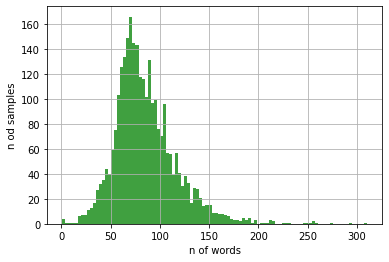

In [10]:
from matplotlib import pyplot as plt

plt.hist(data['WORD_COUNT'], 100, density=False, facecolor='g', alpha=0.75)

plt.xlabel('n of words')
plt.ylabel('n od samples')
plt.grid(True)
plt.show()

In [11]:
data.head(2)

,text,label,WORD_COUNT
0,"He said he had not felt that way before, sugge...",1,113
1,"Hey there r/assistance, Not sure if this is th...",0,108


In [12]:
from torch.utils.data import Dataset, DataLoader

class Stress_FT_Dataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['text']
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [13]:
from transformers import BertTokenizer
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
EPOCHS = 10
LEARNING_RATE = 1e-05
num_classes = 2
batch_size = 80
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
from sklearn.model_selection import train_test_split

train_dataset, valid_dataset = train_test_split(data, random_state=42, test_size = 0.25)
valid_dataset = valid_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_data.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Stress_FT_Dataset(train_dataset, tokenizer, MAX_LEN)
validation_set = Stress_FT_Dataset(valid_dataset, tokenizer, MAX_LEN)

train_loader = DataLoader(training_set, batch_size=batch_size , shuffle=True)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

FULL Dataset: (2838, 3)
TRAIN Dataset: (2128, 3)
VALID Dataset: (710, 3)
TEST Dataset: (715, 2)


In [12]:
next(iter(train_loader))

{'ids': tensor([[ 101, 4931, 7955,  ...,    0,    0,    0],
         [ 101, 2002, 4541,  ..., 2002, 1521,  102],
         [ 101, 1008, 2079,  ...,    0,    0,    0],
         ...,
         [ 101, 7632, 1010,  ...,    0,    0,    0],
         [ 101, 2096, 2002,  ...,    0,    0,    0],
         [ 101, 2061, 2182,  ...,    0,    0,    0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
         1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        

In [15]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [17]:
def train_model(model, dataloaders, criterion, optimizer, checkpoint_path, num_epochs=15):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    # best_acc = 0.0
    wandb.watch(model)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = {'train':0.0, 'val':0.0}
            running_corrects = {'train':0, 'val':0}
            epoch_avg_loss = {'train':0.0, 'val':0.0}
            epoch_avg_acc = {'train':0.0, 'val':0.0}
            epoch_loss_list = {'train':[], 'val':[]}
            epoch_acc_list = {'train':[], 'val':[]}
            epoch_f1_list = {'train':[], 'val':[]}
            global_step = 0
            global_steps_list = []
            stacked_labels = torch.tensor([]).to(device=device)
            stacked_preds = torch.tensor([]).to(device=device)


            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                labels = data['targets'].to(device, dtype = torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # In train mode we calculate the loss by summing the final output
                    # and the auxiliary output but in testing we only consider the final output.
                    
                    outputs = model(ids, mask, token_type_ids)
                    loss = criterion(torch.sigmoid(outputs), labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        global_step += 1
                        wandb.log({'step_train_loss': loss.item(), 'global_step':global_step})

                    stacked_labels = torch.cat([stacked_labels, labels])
                    stacked_preds = torch.cat([stacked_preds, preds])

                    # statistics
                    running_loss[phase] += loss.item() # * labels.size(0)
                    running_corrects[phase] += torch.sum(preds == labels.data)
                    

            epoch_avg_loss[phase] = running_loss[phase] / len(dataloaders[phase].dataset)
            epoch_avg_acc[phase] = running_corrects[phase].double() / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(stacked_labels.cpu(), stacked_preds.cpu())
            epoch_loss_list[phase].append(epoch_avg_loss[phase])
            epoch_acc_list[phase].append(epoch_avg_acc[phase])
            epoch_f1_list[phase].append(epoch_f1)

            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_avg_loss[phase], epoch_avg_acc[phase], epoch_f1))
            
            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_avg_acc[phase])
                wandb.log({"epoch_avg_loss_val": epoch_avg_loss[phase], 'epoch_avg_acc_val':epoch_avg_acc[phase], "epoch_f1":epoch_f1, 'epoch':epoch+1})
            if phase == 'train':
                wandb.log({"epoch_avg_loss_train": epoch_avg_loss[phase], 'epoch_avg_acc_train':epoch_avg_acc[phase], 'epoch':epoch+1})
              
            running_loss[phase] = 0.0
            running_corrects[phase] = 0.0
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)

    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_avg_loss['val'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path)
    return model, val_acc_history

In [19]:
# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
#         self.l2 = torch.nn.Dropout(0.3)
#         self.l3 = torch.nn.Linear(768, 4)
    
#     def forward(self, ids, mask, token_type_ids):
#         _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
#         output_2 = self.l2(output_1)
#         output = self.l3(output_2)
#         return output

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.4)
        self.lstm = nn.LSTM(input_size=768,
                            hidden_size=128,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.l3 = torch.nn.Linear(256, 3)
    
    def forward(self, ids, mask, token_type_ids):
        _, output= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output = self.l2(output).unsqueeze(1)
        output, _ = self.lstm(output)
        output = self.l3(output).squeeze(1)
        return output

# model = BERTClass()

In [20]:
num_classes

2

In [21]:
def initialize_model(pretrained_path, num_classes, use_pretrained=True, gpu=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    input_size = 0
    
    if gpu==True:
      map_location = torch.device('cuda')
    else:
      map_location = torch.device('cpu')
      
    model_ft = BERTClass()
    model_ft.load_state_dict(torch.load(pretrained_path, map_location=map_location)['state_dict'])
    num_ftrs = model_ft.l3.in_features
    model_ft.l3 = nn.Linear(num_ftrs, num_classes)

    return model_ft, input_size


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
PRETRAINED_FSJ_MODEL_PATH = cwd+'/checkpoints/pretrained_FSJ_lstm_lr0.00005_emb_9_unfreeze.pt'
PRETRAINED_FSJ_MODEL_PATH

'/home/svetlana.maslenkova/Documents/nlp_project/checkpoints/pretrained_FSJ_lstm_lr0.00005_emb_9_unfreeze.pt'

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(PRETRAINED_FSJ_MODEL_PATH, num_classes, use_pretrained=True, gpu=False)
model_ft.to(device)
# Print the model we just instantiated
# print(model_ft)

In [ ]:
params_to_update = model_ft.parameters()

for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

In [27]:
from torch.optim import Adam

optimizer_ft = Adam(params_to_update, lr= LEARNING_RATE)

In [28]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = valid_loader

In [29]:
DREDDIT_FT_MODEL_PATH = '/home/svetlana.maslenkova/Documents/nlp_project/checkpoints/FT_FSJ_dreddit_ft_lr0.00005_emb_9_unfreeze.pt'

In [30]:
import wandb

#  Start a new run
wandb.init(project="nlp-project", name='FT_FSJ_dreddit_ft_lr0.00005_emb_9_unfreeze')

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer_ft, num_epochs=50, checkpoint_path=DREDDIT_FT_MODEL_PATH)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maslenkovas (use `wandb login --relogin` to force relogin)


Epoch 1/50
----------
train Loss: 0.0087 Acc: 0.6311 F1: 0.6629
val Loss: 0.0085 Acc: 0.7310 F1: 0.7674

Epoch 2/50
----------
train Loss: 0.0084 Acc: 0.7505 F1: 0.7753
val Loss: 0.0082 Acc: 0.7859 F1: 0.8105

Epoch 3/50
----------
train Loss: 0.0080 Acc: 0.8003 F1: 0.8164
val Loss: 0.0078 Acc: 0.7732 F1: 0.8039

Epoch 4/50
----------
train Loss: 0.0074 Acc: 0.8421 F1: 0.8484
val Loss: 0.0074 Acc: 0.7972 F1: 0.8248

Epoch 5/50
----------
train Loss: 0.0069 Acc: 0.8797 F1: 0.8855
val Loss: 0.0071 Acc: 0.8014 F1: 0.8137

Epoch 6/50
----------
train Loss: 0.0064 Acc: 0.9013 F1: 0.9053
val Loss: 0.0069 Acc: 0.7958 F1: 0.8139

Epoch 7/50
----------
train Loss: 0.0060 Acc: 0.9149 F1: 0.9190
val Loss: 0.0067 Acc: 0.8056 F1: 0.8222

Epoch 8/50
----------
train Loss: 0.0058 Acc: 0.9164 F1: 0.9203
val Loss: 0.0070 Acc: 0.7704 F1: 0.7457

Epoch 9/50
----------
train Loss: 0.0057 Acc: 0.9173 F1: 0.9206
val Loss: 0.0065 Acc: 0.8141 F1: 0.8254

Epoch 10/50
----------
train Loss: 0.0054 Acc: 0.9309 F

wandb: Network error (ReadTimeout), entering retry loop.


train Loss: 0.0050 Acc: 0.9535 F1: 0.9553
val Loss: 0.0065 Acc: 0.8070 F1: 0.8100

Epoch 15/50
----------
train Loss: 0.0049 Acc: 0.9549 F1: 0.9568
val Loss: 0.0067 Acc: 0.7901 F1: 0.8185

Epoch 16/50
----------
train Loss: 0.0049 Acc: 0.9525 F1: 0.9547
val Loss: 0.0065 Acc: 0.7986 F1: 0.8169

Epoch 17/50
----------
train Loss: 0.0048 Acc: 0.9601 F1: 0.9615
val Loss: 0.0065 Acc: 0.8000 F1: 0.8212

Epoch 18/50
----------
train Loss: 0.0048 Acc: 0.9549 F1: 0.9570
val Loss: 0.0065 Acc: 0.8028 F1: 0.8201

Epoch 19/50
----------
train Loss: 0.0048 Acc: 0.9601 F1: 0.9618
val Loss: 0.0064 Acc: 0.8127 F1: 0.8248

Epoch 20/50
----------
train Loss: 0.0047 Acc: 0.9676 F1: 0.9690
val Loss: 0.0067 Acc: 0.7845 F1: 0.8127

Epoch 21/50
----------
train Loss: 0.0047 Acc: 0.9633 F1: 0.9648
val Loss: 0.0065 Acc: 0.8000 F1: 0.8184

Epoch 22/50
----------
train Loss: 0.0046 Acc: 0.9695 F1: 0.9708
val Loss: 0.0065 Acc: 0.8042 F1: 0.8088

Epoch 23/50
----------
train Loss: 0.0047 Acc: 0.9624 F1: 0.9639
val 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_avg_acc_train,▁▃▄▅▆▇▇▇▇▇██▇███████████████████████████
epoch_avg_acc_val,▁▆▅▇▆▇▄█▇▇█▇▇▇▇█▇▇▇▇▆▇▇█▆▇▆▆▆▇▇▆▆▇▆▇▆▇▆▆
epoch_avg_loss_train,██▇▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_avg_loss_val,█▇▆▄▃▂▃▁▁▁▁▁▂▂▁▁▂▁▁▁▂▁▂▁▂▁▂▂▂▁▁▂▂▂▂▁▂▁▂▂
epoch_f1,▃▆▆█▇▇▁█▇██▆▇▇▇█▇▆▇▆▆▇▇█▇▆▇▇▅▇▆▇▇▆▇▇▅▆▆▇
global_step,▅▆█▂▃▅▆▇▆▇▁▂▄▅▆█▆▇▂▃▄▆▇▁▇█▂▃▅▆▇▂▇▁▃▄▅▇█▆
step_train_loss,██▇▅▅▄▃▄▃▂▂▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁▁
epoch,50
epoch_avg_acc_train,0.97791
epoch_avg_acc_val,0.79014


### Evaluating the model

In [85]:
def load_checkpoint(load_path, model, optimizer):
  if load_path==None: return

  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')

  model.load_state_dict(state_dict['state_dict'])
  optimizer.load_state_dict(state_dict['optimizer'])

  return state_dict['valid_loss_min']


In [47]:
load_checkpoint(CHECKPOINT_FT_PATH, model_ft, optimizer_ft)

Model loaded from <== /content/drive/MyDrive/MBZUAI/NLP702/project/checkpoints/ft_ekman_ft_dreddit.pt


0.03951466697412477

In [25]:
test_data = pd.read_csv(TEST_DATA_PATH)[['text', 'label']]
test_data.head(1)

,text,label
0,"Its like that, if you want or not.“ ME: I have...",0


In [26]:
test_set = Stress_FT_Dataset(test_data, tokenizer, MAX_LEN)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16)

In [29]:
evaluate(model_ft, test_data)

Test Accuracy:  0.776


# Training classifier for Dreddit with corrected labels:

In [22]:
train_data_corrected = pd.read_csv(CORRECTED_LABELS_DATA_PATH)
for new_label, label, text  in zip(train_data_corrected.head().final_labels, \
                                    train_data_corrected.head().is_stress, \
                                        train_data_corrected.head().selftext):
    print(f'NEW_LABEL: {new_label}, OLD LABEL: {label}\n', text)

NEW_LABEL: 1, OLD LABEL: 1
 The book is available [Here](https://thewellnesssociety.org/free-coronavirus-anxiety-workbook/) from The Wellness Society. Everyone right now needs a little extra help and hopefully, this e-book can assist some of you in uncovering the toolset you need during this abnormal time, or at least it might help with bridging the gap between now and when you may be able to seek more professional assistance. Obviously, it's not a solution to all problems, and some of you are going to be going through a lot more than others, but I hope many of you can find it useful.
Stay safe, stay healthy.
NEW_LABEL: 1, OLD LABEL: 1
 I am just wondering, because I have some problems with thinking/focusing/remembering 24/7, and I am also quite a stressful person, so I figured that chronic stress may be the main culprit.

[View Poll](https://www.reddit.com/poll/u9k398)
NEW_LABEL: 1, OLD LABEL: 1
 Hey reddit,

I'm going to keep this somewhat short as I have only just two days ago recog

In [28]:
train_data_dreddit = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

data_corrected = train_data_corrected[['selftext', 'final_labels']].copy()\
                                    .rename(columns={'selftext':'text', 'final_labels':'label'})

data_dreddit = train_data_dreddit[['text', 'label']].copy()

test_data = test_data[['text', 'label']].copy()

In [40]:
data = pd.concat([data_dreddit, data_corrected]).sample(frac=1)
print(data.shape)

(8790, 2)


In [41]:
print('shape of the train dataset: ', data.shape)
print('number of positve samples: ', data[data.label==1].shape[0])
print('number of negative samples: ', data[data.label==0].shape[0])
print('the ratio of neg to pos: ', np.round(data[data.label==0].shape[0]/data[data.label==1].shape[0], 2))
print('shape of the test dataset: ', test_data.shape)
data.head()

shape of the train dataset:  (8790, 2)
number of positve samples:  7280
number of negative samples:  1510
the ratio of neg to pos:  0.21
shape of the test dataset:  (715, 2)


,text,label
1344,Anxiety keeps hitting me real bad at night and...,1
1354,I paid off some of my credit card debt a coupl...,1
2414,"hi, I'm in CA. has anyone had to find a lawyer...",1
1167,I should most likely be going to college in Se...,0
2118,I hide my own set of keys. She tries to take h...,1


In [37]:
from transformers import BertTokenizer
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
EPOCHS = 30
LEARNING_RATE = 1e-05
num_classes = 2
batch_size = 64
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
from sklearn.model_selection import train_test_split

train_dataset, valid_dataset = train_test_split(data, random_state=42, test_size = 0.1)
valid_dataset = valid_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_data.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Stress_FT_Dataset(train_dataset, tokenizer, MAX_LEN)
validation_set = Stress_FT_Dataset(valid_dataset, tokenizer, MAX_LEN)

train_loader = DataLoader(training_set, batch_size=batch_size , shuffle=True)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = valid_loader

FULL Dataset: (8790, 2)
TRAIN Dataset: (7911, 2)
VALID Dataset: (879, 2)
TEST Dataset: (715, 2)


In [46]:
class BERTClass_Dreddit(torch.nn.Module):
    def __init__(self):
        super(BERTClass_Dreddit, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 2)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model_no_emo_ft = BERTClass_Dreddit()
model_no_emo_ft.to(device)

In [51]:
from torch.optim import Adam

optimizer_no_emo_ft = Adam(model_no_emo_ft.parameters(), lr= LEARNING_RATE)

In [52]:
CHECKPOINT_NOEMO_CORRECTED_FT = cwd + '/checkpoints/checkpoint_noemo_ft_dreddit_corrected_ft.pt'

In [55]:
import wandb

#  Start a new run
wandb.init(project="nlp-project", name="no_emo_ft_dreddit_corrected_ft")

# Train and evaluate
model_no_emo_ft, hist = train_model(model_no_emo_ft, dataloaders_dict, loss_fn, optimizer_no_emo_ft, num_epochs=30, checkpoint_path=CHECKPOINT_NOEMO_CORRECTED_FT)

wandb.finish()

Epoch 1/30
----------
train Loss: 0.0080 Acc: 0.8307
val Loss: 0.0073 Acc: 0.8555

Epoch 2/30
----------
train Loss: 0.0070 Acc: 0.8702
val Loss: 0.0071 Acc: 0.8703

Epoch 3/30
----------
train Loss: 0.0067 Acc: 0.8934
val Loss: 0.0070 Acc: 0.8737

Epoch 4/30
----------
train Loss: 0.0063 Acc: 0.9161
val Loss: 0.0070 Acc: 0.8726

Epoch 5/30
----------
train Loss: 0.0061 Acc: 0.9277
val Loss: 0.0069 Acc: 0.8771

Epoch 6/30
----------
train Loss: 0.0059 Acc: 0.9391
val Loss: 0.0069 Acc: 0.8783

Epoch 7/30
----------
train Loss: 0.0058 Acc: 0.9415
val Loss: 0.0070 Acc: 0.8726

Epoch 8/30
----------
train Loss: 0.0058 Acc: 0.9448
val Loss: 0.0068 Acc: 0.8851

Epoch 9/30
----------
train Loss: 0.0057 Acc: 0.9501
val Loss: 0.0069 Acc: 0.8783

Epoch 10/30
----------
train Loss: 0.0057 Acc: 0.9504
val Loss: 0.0068 Acc: 0.8851

Epoch 11/30
----------


# Training simple classifier for Dreddit:

## Training

In [25]:
class BERTClass_Dreddit(torch.nn.Module):
    def __init__(self):
        super(BERTClass_Dreddit, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 2)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [26]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = TRAIN_DATA_PATH

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False


In [38]:
from transformers import BertTokenizer
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
EPOCHS =30
LEARNING_RATE = 0.0001
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [39]:
from sklearn.model_selection import train_test_split

train_dataset, valid_dataset = train_test_split(data, random_state=42, test_size = 0.2)
valid_dataset = valid_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_data.reset_index(drop=True)


print("FULL (train+val) Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Stress_FT_Dataset(train_dataset, tokenizer, MAX_LEN)
validation_set = Stress_FT_Dataset(valid_dataset, tokenizer, MAX_LEN)

train_loader = DataLoader(training_set, batch_size=batch_size , shuffle=True)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = valid_loader

FULL (train+val) Dataset: (2838, 3)
TRAIN Dataset: (2270, 3)
VALID Dataset: (568, 3)
TEST Dataset: (715, 2)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model_no_emo_ft = BERTClass_Dreddit()
model_no_emo_ft.to(device)

In [42]:
from torch.optim import Adam

optimizer_no_emo_ft = Adam(model_no_emo_ft.parameters(), lr= LEARNING_RATE)

In [43]:
LEARNING_RATE

0.0001

In [ ]:
wandb.finish()

In [44]:
CHECKPOINT_NOEMO_FT = cwd + '/checkpoints/checkpoint_noemo_ft_dreddit_lr0.0001.pt'

In [31]:
import wandb
wandb.__version__

'0.12.15'

In [45]:
import wandb

#  Start a new run
wandb.init(project="nlp-project", name="no_emo_ft_dreddit_ft_lr0.0001")

# Train and evaluate
model_no_emo_ft, hist = train_model(model_no_emo_ft, dataloaders_dict, loss_fn, optimizer_no_emo_ft, num_epochs=30, checkpoint_path=CHECKPOINT_NOEMO_FT)

wandb.finish()

Epoch 1/30
----------
train Loss: 0.0096 Acc: 0.6952 F1: 0.7171
val Loss: 0.0083 Acc: 0.7764 F1: 0.8000

Epoch 2/30
----------
train Loss: 0.0078 Acc: 0.8185 F1: 0.8262
val Loss: 0.0092 Acc: 0.7289 F1: 0.7890

Epoch 3/30
----------
train Loss: 0.0077 Acc: 0.8242 F1: 0.8311
val Loss: 0.0087 Acc: 0.7606 F1: 0.7597

Epoch 4/30
----------
train Loss: 0.0071 Acc: 0.8573 F1: 0.8661
val Loss: 0.0082 Acc: 0.7887 F1: 0.8148

Epoch 5/30
----------
train Loss: 0.0064 Acc: 0.9070 F1: 0.9117
val Loss: 0.0082 Acc: 0.7905 F1: 0.8138

Epoch 6/30
----------
train Loss: 0.0062 Acc: 0.9233 F1: 0.9255
val Loss: 0.0090 Acc: 0.7394 F1: 0.7228

Epoch 7/30
----------
train Loss: 0.0062 Acc: 0.9154 F1: 0.9186
val Loss: 0.0086 Acc: 0.7535 F1: 0.7941

Epoch 8/30
----------
train Loss: 0.0059 Acc: 0.9374 F1: 0.9402
val Loss: 0.0083 Acc: 0.7835 F1: 0.8069

Epoch 9/30
----------
train Loss: 0.0056 Acc: 0.9604 F1: 0.9621
val Loss: 0.0082 Acc: 0.7905 F1: 0.8040

Epoch 10/30
----------
train Loss: 0.0054 Acc: 0.9705 F

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch_avg_acc_train,▁▄▄▅▆▇▇▇████▇▇██▇▆▄▆▇▇▆▇█▇████
epoch_avg_acc_val,▇▄▆██▄▅██▇▇▂▅▇▆▃▄▁▅▄▄▅▄▅▆▅▆▄▃▃
epoch_avg_loss_train,█▅▅▄▃▂▂▂▁▁▁▁▂▂▁▁▂▄▅▂▂▂▃▂▁▂▁▁▁▁
epoch_avg_loss_val,▂▅▃▁▁▄▃▁▁▂▂▇▅▂▃▅▅█▄▅▅▅▅▃▄▄▃▅▆▆
epoch_f1,▇▆▄██▂▇▇▇██▆▃▆▆▁▄▅▅▅▃▆▅▆▆▆▇▃▁▂
global_step,▄▇▆▅▁█▇▃▂▁▅▄▃▂▅▅▄▇▆▅▁█▇▃▂▁█▄▃▂▅▅▄▇▆▅▁█▇▆
step_train_loss,██▆▆▂▄▆▃▃▂▂▂▁▂▂▁▂▃▁▁▂▃▄▇▇▄▂▂▂▃▂▃▂▄▂▁▂▂▃▁
epoch,30
epoch_avg_acc_train,0.95551
epoch_avg_acc_val,0.71479


## Evaluation

In [31]:
from sklearn.metrics import classification_report

def evaluate(model, test_data, use_cuda=False):

    test = Stress_FT_Dataset(test_data, tokenizer, MAX_LEN)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    # use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda==True else "cpu")
    model = model.to(device)
    stacked_labels = torch.tensor([])
    stacked_preds = torch.tensor([])

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for batch_idx, data in enumerate(test_dataloader):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.int)

            output = model(ids, mask, token_type_ids)
            output = torch.sigmoid(output).cpu()
            preds = torch.tensor(np.array(output.detach().numpy()) > 0.5).to(device, dtype = torch.int)
            preds = preds.argmax(dim=1)
            acc = (preds == targets).sum().item()
            total_acc_test += acc
            stacked_labels = torch.cat([stacked_labels, targets])
            stacked_preds = torch.cat([stacked_preds, preds])
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(classification_report(stacked_labels, stacked_preds, output_dict=False))

    return classification_report(stacked_labels, stacked_preds, output_dict=True)
    

In [23]:
DREDDIT_FT_MODEL_PATH

'/home/svetlanamaslenkova/Documents/nlp_project/checkpoints/full_ekman_ft_dreddit_ft.pt'

In [115]:
load_checkpoint(DREDDIT_FT_MODEL_PATH, model_ft, optimizer_ft)

Model loaded from <== /home/svetlanamaslenkova/Documents/nlp_project/checkpoints/4cat_ft_dreddit_ft.pt


0.008365489542484283

In [32]:
device = 'cpu'
print(device)

cpu


In [33]:
model_ft = model_ft.to(device)

In [34]:
test_data = pd.read_csv(TEST_DATA_PATH)[['text', 'label']]

test_set = Stress_FT_Dataset(test_data, tokenizer, MAX_LEN)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16)

In [35]:
evaluate(model_ft, test_data)

Test Accuracy:  0.783
              precision    recall  f1-score   support

         0.0       0.82      0.71      0.76       346
         1.0       0.76      0.86      0.80       369

    accuracy                           0.78       715
   macro avg       0.79      0.78      0.78       715
weighted avg       0.79      0.78      0.78       715



{'0.0': {'precision': 0.8215488215488216,
  'recall': 0.7052023121387283,
  'f1-score': 0.7589424572317263,
  'support': 346},
 '1.0': {'precision': 0.7559808612440191,
  'recall': 0.8563685636856369,
  'f1-score': 0.8030495552731893,
  'support': 369},
 'accuracy': 0.7832167832167832,
 'macro avg': {'precision': 0.7887648413964203,
  'recall': 0.7807854379121826,
  'f1-score': 0.7809960062524578,
  'support': 715},
 'weighted avg': {'precision': 0.7877102518250843,
  'recall': 0.7832167832167832,
  'f1-score': 0.7817054211160619,
  'support': 715}}